# Load data

We start by loading train & test data, and adding initial motion info:

In [ ]:
import pandas as pd 
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
root_dir = os.getcwd()

games_fname= os.path.join(root_dir, "data/games.csv")
plays_fname = os.path.join(root_dir,  "data/plays.csv")
df_plays = pd.read_csv(os.path.join(root_dir,'data/plays.csv'))
train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
print('train colums: ', len(train_data.columns))
print('test colums: ', len(test_data.columns))

train colums:  463
test colums:  367


In [4]:
include_columns=[x for x in test_data.columns if '_def' not in x]+['pass_rate_def']
train_data=train_data[include_columns]
test_data = test_data[include_columns]

We define functions to get us all motion/momentum columns:

In [6]:
def get_momentum_cols(final_features):
    momentum_cols=[]
    for f in final_features:
        if 'shiftSinceLineset' in f:
            momentum_cols.append(f)
    return momentum_cols

In [7]:
def get_motion_cols(final_features):
    motion_cols=[]
    for f in final_features:
        if 'motionSinceLineset' in f:
            motion_cols.append(f)
    return motion_cols

In [8]:
motion_cols=get_motion_cols(train_data.columns)
momentum_cols=get_momentum_cols(train_data.columns)

### Compute accel/speed/distance maxima for each offensive play

For each player who went in motion, we get their maximum speed & acceleration, as well as sum distance travelled.

For each of these three metrics, we then get the maximum value among these in-motion players.

In [ ]:
def get_motion_maxima(row):
    a_max = 0
    s_max = 0
    d_sum = 0
    for col in motion_cols:
        if row[col]:
            curr_pos = col.split('|')[1]
            curr_amax = row['a|max|'+curr_pos]
            curr_smax = row['s|max|'+curr_pos]
            curr_dmax = row['dis|sum|'+curr_pos]
            if curr_amax > a_max:
                a_max = curr_amax
            if curr_smax > s_max:
                s_max = curr_smax
            if curr_dmax > d_sum:
                d_sum = curr_dmax

    return [a_max, s_max, d_sum]

Apply function/integrate it back into data:

In [12]:
accel_ls = []
speed_ls = []
dis_ls = []
for idx, row in train_data.iterrows():
    a,s,dis = get_motion_maxima(row)
    accel_ls.append(a)
    speed_ls.append(s)
    dis_ls.append(dis)

In [ ]:
train_data['off_motion_amax'] = accel_ls
train_data['off_motion_smax'] = speed_ls
train_data['off_motion_dsum'] = dis_ls

# Integrate defensive data

In a separate notebook, we computed similar speed/accel/distance maxima for defense. We now integrate them:

In [15]:
def_only = pd.read_csv('data/def_maxima.csv')
def_only.head(3)

,gameId,playId,def_a_max,def_s_max,def_dis_max
0,2022090800,56,3.31,3.65,18.76
1,2022090800,80,2.59,2.25,8.33
2,2022090800,101,2.25,2.85,13.46


In [16]:
train_data = train_data.merge(def_only,how='left')

Calculat deltas between offense/defense play-level maxima:

In [17]:
train_data['accel_max_delta'] = train_data['off_motion_amax']-train_data['def_a_max']
train_data['speed_max_delta'] = train_data['off_motion_smax']-train_data['def_s_max']
train_data['distance_max_delta'] = train_data['off_motion_dsum']-train_data['def_s_max']

We now examine the relation between our new features and whether the team passed:

In [ ]:
train_data['motion_sum'] = train_data[motion_cols].sum(axis=1)
train_data['counted_dist'] = train_data['off_motion_dsum']-.3*train_data['motion_sum']

In [23]:
train_data.corr()['pass'][['counted_dist','off_motion_amax','off_motion_smax','off_motion_dsum','accel_max_delta','speed_max_delta','distance_max_delta','motion_sum']]

counted_dist          0.194487
off_motion_amax       0.155582
off_motion_smax       0.176048
off_motion_dsum       0.194580
accel_max_delta       0.150124
speed_max_delta       0.163564
distance_max_delta    0.195919
motion_sum            0.160328
Name: pass, dtype: float64

### Explore features visually

The below graphs break out our metrics by offense, defense, and the delta between the two:

In [25]:
train_motion = train_data[train_data['motion_sum'] > 0]

In [26]:
y1_mean = [train_motion['off_motion_amax'].mean(),train_motion['def_a_max'].mean(),train_data['accel_max_delta'].mean()]
y2_mean = [train_motion['off_motion_smax'].mean(),train_motion['def_s_max'].mean(),train_data['speed_max_delta'].mean()]
y3_mean = [train_motion['off_motion_dsum'].mean(),train_motion['def_dis_max'].mean(),train_data['distance_max_delta'].mean()]

First we examine the average team-high values, by play, of accel, speed, and distance traveled:

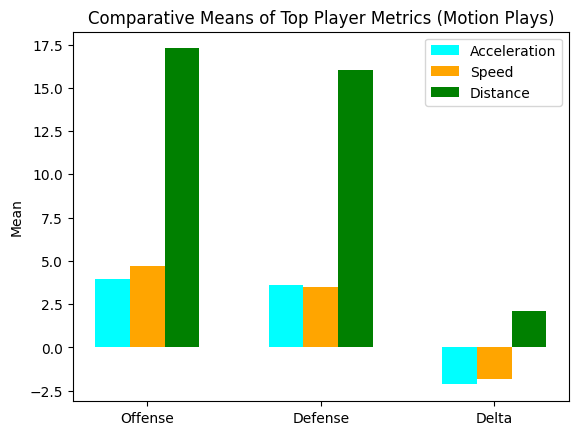

In [27]:
# importing package 
import matplotlib.pyplot as plt 
import numpy as np 

# create data 
x = np.arange(3) 
width = 0.2

# plot data in grouped manner of bar type 
plt.bar(x-width, y1_mean, width, color='cyan') 
plt.bar(x, y2_mean, width, color='orange') 
plt.bar(x+width, y3_mean, width, color='green') 
plt.xticks(x, ['Offense', 'Defense','Delta']) 
#plt.xlabel("Group") 
plt.ylabel("Mean") 
plt.legend(["Acceleration", "Speed", "Distance"]) 
plt.title('Comparative Means of Top Player Metrics (Motion Plays)')
plt.show() 

In [28]:
y1_median = [train_motion['off_motion_amax'].median(),train_motion['def_a_max'].median(),train_data['accel_max_delta'].median()]
y2_median = [train_motion['off_motion_smax'].median(),train_motion['def_s_max'].median(),train_data['speed_max_delta'].median()]
y3_median = [train_motion['off_motion_dsum'].median(),train_motion['def_dis_max'].median(),train_data['distance_max_delta'].median()]

We do the same, but with the median values now:

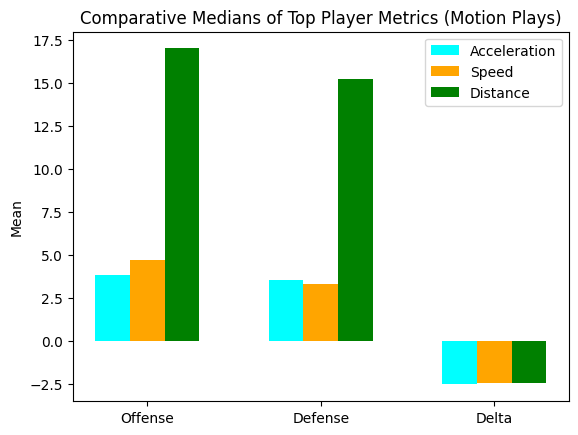

In [29]:
# importing package 
import matplotlib.pyplot as plt 
import numpy as np 

# create data 
x = np.arange(3) 
width = 0.2

# plot data in grouped manner of bar type 
plt.bar(x-width, y1_median, width, color='cyan') 
plt.bar(x, y2_median, width, color='orange') 
plt.bar(x+width, y3_median, width, color='green') 
plt.xticks(x, ['Offense', 'Defense','Delta']) 
#plt.xlabel("Group") 
plt.ylabel("Mean") 
plt.legend(["Acceleration", "Speed", "Distance"]) 
plt.title('Comparative Medians of Top Player Metrics (Motion Plays)')
plt.show() 

### Further metric engineering

We try and figure out different ways to slice our shift/motion data, but to little avail. While inverting the motion-shift difference looks promising, a test actually showed it negatively impacted performance (~4% decrease to 77% test accuracy).

In [37]:
train_data['shift_sum'] = train_data[momentum_cols].sum(axis=1)
train_data['ms_delta'] = train_data['motion_sum'] - train_data['shift_sum']
train_data['ms_flag'] = (train_data['ms_delta'] > 0).astype(int)
train_data['ms_flag'] = train_data['ms_flag'].replace(0,-1)
train_data['ms_adj'] = train_data['ms_flag'] * train_data['off_motion_dsum']
train_data['inv_delta'] = 1/train_data['ms_delta']

In [93]:
train_data[['ms_delta','ms_adj','motion_sum','shift_sum','pass','off_motion_dsum','inv_delta']].corr()['pass']

ms_delta           0.225410
ms_adj             0.175614
motion_sum         0.160328
shift_sum         -0.139762
pass               1.000000
off_motion_dsum    0.194580
inv_delta          0.364604
Name: pass, dtype: float64

In [94]:
train_data[['ms_delta','ms_adj','motion_sum','shift_sum','pass','off_motion_dsum','inv_delta']].corr()

,ms_delta,ms_adj,motion_sum,shift_sum,pass,off_motion_dsum,inv_delta
ms_delta,1.000000,0.662583,0.697500,-0.634882,0.225410,0.649691,0.854509
ms_adj,0.662583,1.000000,0.582020,-0.291422,0.175614,0.821467,0.757583
motion_sum,0.697500,0.582020,1.000000,0.110810,0.160328,0.804164,0.751245
shift_sum,-0.634882,-0.291422,0.110810,1.000000,-0.139762,-0.034029,-0.725465
pass,0.225410,0.175614,0.160328,-0.139762,1.000000,0.194580,0.364604
off_motion_dsum,0.649691,0.821467,0.804164,-0.034029,0.194580,1.000000,0.747589
inv_delta,0.854509,0.757583,0.751245,-0.725465,0.364604,0.747589,1.000000
